In [1]:
from pathlib import Path
import os
import sys

sys.path.append(Path(os.path.abspath('')).parent.parent)
os.chdir(Path(os.path.abspath('')).parent.parent)

import geopandas as gpd
import pandas as pd
import numpy as np

import config.settings as cset
from config.settings import (labelsize_small, 
                            labelsize_medium, 
                            labelsize_large,
                            focus_countries,
                            focus_countries_names,
                            focus_countries_colors, 
                            focus_scenarios,
                            focus_scenarios_color_dict,
                            focus_scenarios_labels,
                            cmap_diverging,
                            path_CLUSTER_results,
                            colors_clusters
                            )

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import box
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap

from tqdm.notebook import tqdm

In [10]:
classification_df = pd.read_csv(path_CLUSTER_results / 'growth_classification.csv')

In [11]:
classification_df

,Unnamed: 0,scen,iso,run,category,scen_run,gmt_exc
0,0,CurPol,AFG,1,growt,CurPol_1,0.818272
1,1,CurPol,AFG,10,growt,CurPol_10,0.368022
2,2,CurPol,AFG,100,growt,CurPol_100,0.854601
3,3,CurPol,AFG,11,growt,CurPol_11,0.368022
4,4,CurPol,AFG,12,growt,CurPol_12,0.458840
...,...,...,...,...,...,...,...
156995,156995,ssp534-over,ZWE,95,growt,ssp534-over_95,0.529676
156996,156996,ssp534-over,ZWE,96,growt,ssp534-over_96,0.488738
156997,156997,ssp534-over,ZWE,97,growt,ssp534-over_97,0.488738
156998,156998,ssp534-over,ZWE,98,growt,ssp534-over_98,0.976988


In [12]:
counts = []
for i in range(1,101):
    counts.append(len(classification_df[(classification_df.scen == 'Ref') & (classification_df.category == 'nogro') & (classification_df.run == i)].iso.unique()))
print(np.quantile(counts, [0.05, 0.5, 0.95])/157)


[0.         0.00636943 0.03184713]


In [13]:
years = np.arange(2015,2101,1)
y_growth_accelerating     = 0.13*np.exp(0.04*(years-2015))-1.63
y_growth_constant         = 0.041*(years-2015)-1.5
y_growth_slowing          = 1.4*np.log(0.1*(years-2014)+0.9)-1.5
y_growth_complex          = 2.23827367*10**(-12)*years**5  - 6.40624342*10**(-9)*years**4 - 7.56066177*10**(-6)*years**3 +  1.53649475*10**(-2)*years**2 + 5.54010968*10**1*years - 8.09050281*10**4
y_stagnation_normal       = -0.000533*(years-2015)**2+0.069*(years-2015)-1.5
y_stagnation_normal[63:]  = 0.73
y_stagnation_complex      = 3.032952801004872e-08*years**5-0.0003133029502560941*years**4+1.2944615357045461*years**3-2673.926959661213*years**2+2761503.1360722124*years-1140688424.188846-0.78
y_nogrowth_normal           = -0.00066115702*(years-2015)**2+0.07272727272*(years-2015)-1.5
y_nogrowth_complex          = 7.697877562439336e-08*years**5 + -0.000793981717365918*years**4 + 3.275521122253075*years**3 + -6756.016333993602*years**2 + 6966928.2130272165*years**1 + -2873573436.7270246-1.5

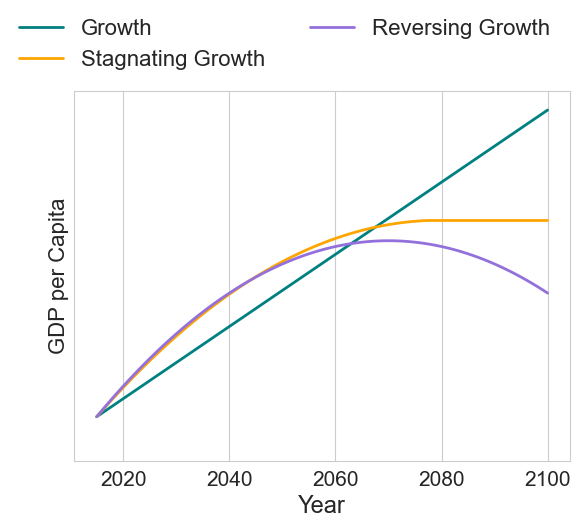

In [14]:
colors_clusters = colors = ['teal', 
                            'orange', 
                            'mediumpurple']
default_linewidth = 2
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots()
    ax.plot(years, y_growth_constant, linewidth = default_linewidth, color = colors_clusters[0], label = 'Growth')
    ax.plot(years, y_stagnation_normal, linewidth = default_linewidth, color = colors_clusters[1], label = 'Stagnating Growth')
    ax.plot(years, y_nogrowth_normal, linewidth = default_linewidth, color = colors_clusters[2], label = 'Reversing Growth')
    
    ax.set_ylim(bottom = -2, top = 2.2)
    ax.set_yticks([])
    ax.set_xticks([2020,2040,2060,2080,2100],
                  [2020,2040,2060,2080,2100], 
                  fontsize = labelsize_small) 
    ax.set_ylabel('GDP per Capita',
                  fontsize = labelsize_medium)
    ax.set_xlabel('Year', 
                  fontsize = labelsize_large)
    ax.legend(edgecolor = 'none', 
              facecolor = (1,1,1,.7), 
              fontsize = labelsize_medium,
              ncols = 2, 
              bbox_to_anchor = (1,1.25))
    plt.show()

In [8]:
# # exogenous reference growth rates:
# gdp_df   = pd.read_csv(cset.file_burke).loc[:, ['iso', 'scen', 'run', 'year', 'diff_SSP2', 'SSP2', 'SSP2_clim']]
# SSP2_rates = pd.DataFrame(index = gdp_df.iso.unique(), columns = [2050, 2075, 2100])
# for iso in tqdm(SSP2_rates.index, total = len(SSP2_rates.index)): 
#     for year in SSP2_rates.columns:
#         SSP2_rates.loc[iso, year] = gdp_df.loc[(gdp_df.iso == iso) & (gdp_df.year == year), 'SSP2'].values[0]/ gdp_df.loc[(gdp_df.iso == iso) & (gdp_df.year == year-1), 'SSP2'].values[0]

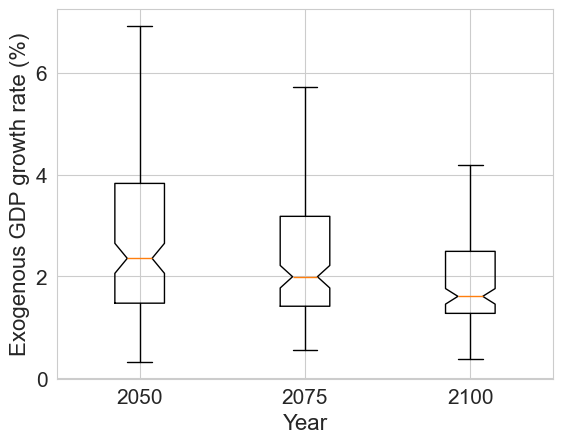

In [15]:
SSP2_rates = pd.read_csv(path_CLUSTER_results / 'SSP2_rates.csv', index_col = 0)
with sns.axes_style('whitegrid'):
    fig, ax  = plt.subplots()
    ax.boxplot((SSP2_rates.values-1)*100, notch = True)
    ax.set_xticks([1,2,3], ['2050', '2075', '2100'], fontsize = labelsize_small)
    ax.set_ylabel('Exogenous GDP growth rate (%)', fontsize = labelsize_medium)
    ax.set_yticks([0,2,4,6],
                  [0,2,4,6],
                  fontsize = labelsize_small)
    ax.set_xlabel('Year', fontsize = labelsize_medium)
    plt.show()

In [16]:
exceedence_tmps_all = []
hist_counts_all = []
bins_all = []
n_bins = 6
for i, category in enumerate(['growt', 'stagn', 'nogro']):
    exceedence_tmp = classification_df[classification_df.category == category].loc[:, 'gmt_exc'].values
    exceedence_tmps_all.append(exceedence_tmp)
    counts, bins = np.histogram(exceedence_tmp, bins  = n_bins, range = (0, 1.8))
    hist_counts_all.append(counts)
    bins_all.append(bins)
bin_centers = (bins_all[0][:-1] + bins_all[0][1:])/2
print(bin_centers)

[0.15 0.45 0.75 1.05 1.35 1.65]


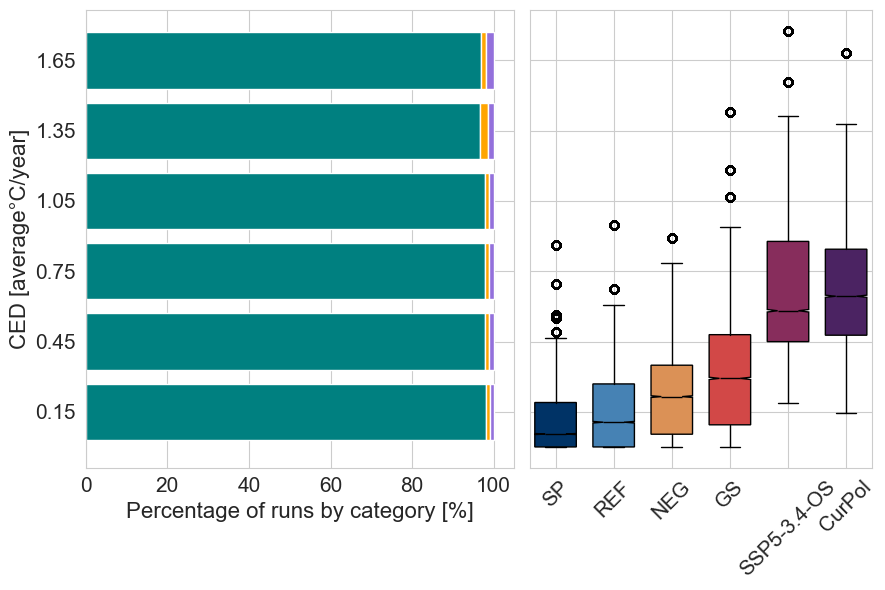

In [17]:
bottoms = [0]*n_bins
width = bin_centers[0]*1.6
total = np.sum(hist_counts_all, axis = 0)
hspace = 7
deltah = 5

with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(1, 2, figsize = (9, 6), width_ratios=[1,0.8], sharey = True)
    ax = axes[0]
    for i in range(3):
        ax.barh(bin_centers,
               np.array(hist_counts_all)[i]/total*100,
               left = bottoms, 
               color = colors_clusters[i],
               height = width)
        bottoms += np.array(hist_counts_all)[i]/total*100
    ax.set_xticks([0, 20, 40, 60, 80, 100], 
                  [0, 20, 40, 60, 80, 100],
                  fontsize = labelsize_small)
    ax.set_yticks(np.round(bin_centers,2),
                  np.round(bin_centers,2),
                  fontsize = labelsize_small)
    ax.set_ylabel('CED [average°C/year]', 
                 fontsize = labelsize_medium)
    ax.set_xlabel('Percentage of runs by category [%]', 
                 fontsize = labelsize_medium)
    ax = axes[1]
    for i, scen in enumerate(focus_scenarios):
        bar = ax.boxplot(classification_df[classification_df.scen == scen].loc[:, 'gmt_exc'].values,
                         positions = [hspace*i], 
                         widths = deltah, 
                         patch_artist = True, 
                         boxprops=dict(facecolor=focus_scenarios_color_dict[scen], color='black'),
                         vert = True,
                         notch = True) 
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bar[element], color='black')
    ax.set_xticks([hspace*i for i in range(len(focus_scenarios))], 
                  focus_scenarios_labels,
                  fontsize = labelsize_small,
                  rotation = 45)
    ax.axis()
    fig.tight_layout()
    plt.show()

In [18]:
import geopandas as gpd 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

classification_counts_df = classification_df.loc[:, ['scen', 'iso', 'category']].copy()
classification_counts_df.loc[:, 'category_binary'] = 0 
classification_counts_df.loc[classification_counts_df.category == 'nogro', 'category_binary'] = 1 
classification_counts_df = classification_counts_df.loc[:, ['scen', 'iso', 'category_binary']].groupby(['scen', 'iso']).sum().reset_index()

gdp_isos = classification_counts_df.iso.unique()
for scenario in cset.scenarios: 
    world[f'no_growth_count_{scenario}'] = np.nan
    world.loc[gdp_isos, f'no_growth_count_{scenario}'] = classification_counts_df.loc[classification_counts_df.scen == scenario, 'category_binary'].values

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_18846/1882551957.py:138: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout(h_pad= 0.5)


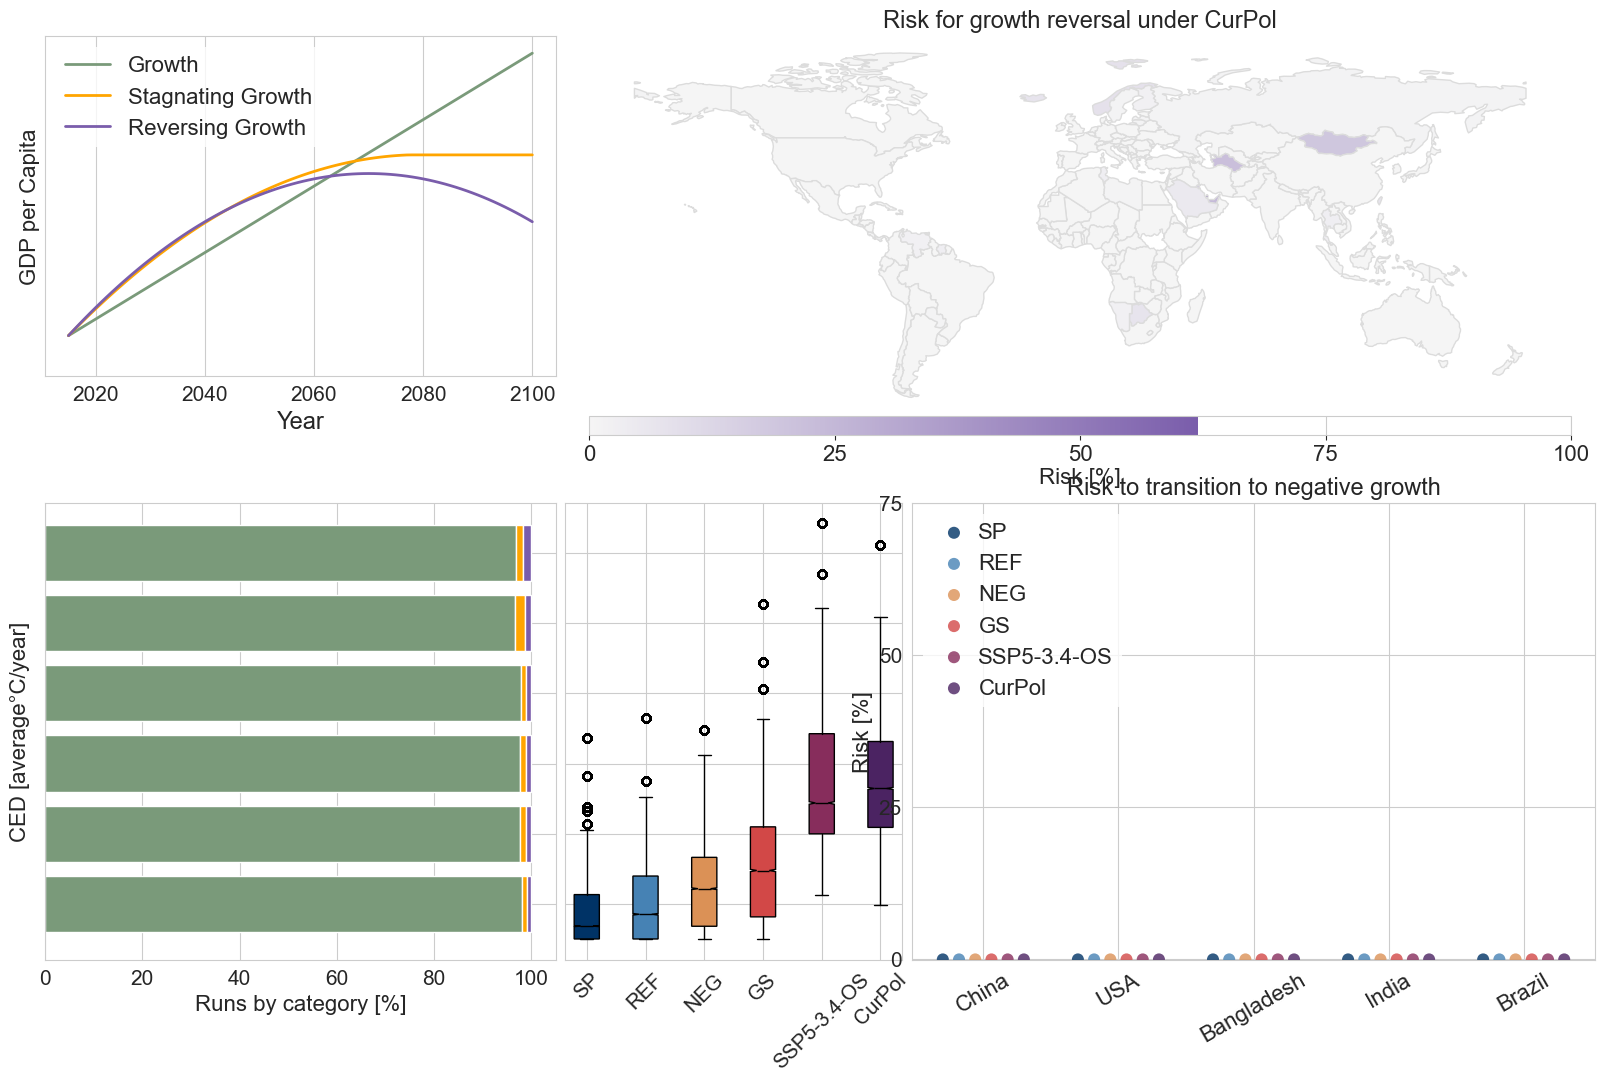

In [19]:
# build one graphic 
colors_clusters = colors = ['#7A9A7A', 
                            'orange', 
                            '#7A5DAB']
axes = []
with sns.axes_style('whitegrid'): 
        fig = plt.figure(figsize=(20, 12))
        gs  = GridSpec(16, 27, figure=fig)

        # add categorization:
        ax = fig.add_subplot(gs[:6,:9])
        ax.plot(years, y_growth_constant, linewidth = default_linewidth, color = colors_clusters[0], label = 'Growth')
        ax.plot(years, y_stagnation_normal, linewidth = default_linewidth, color = colors_clusters[1], label = 'Stagnating Growth')
        ax.plot(years, y_nogrowth_normal, linewidth = default_linewidth, color = colors_clusters[2], label = 'Reversing Growth')
        
        ax.set_ylim(bottom = -2, top = 2.2)
        ax.set_yticks([])
        ax.set_xticks([2020,2040,2060,2080,2100],
                        [2020,2040,2060,2080,2100], 
                        fontsize = labelsize_small) 
        ax.set_ylabel('GDP per Capita',
                        fontsize = labelsize_medium)
        ax.set_xlabel('Year', 
                        fontsize = labelsize_large)
        ax.legend(edgecolor = 'none', 
                facecolor = (1,1,1,.7), 
                fontsize = labelsize_medium,
                ncols = 1, 
                loc = 'upper left')   
        axes.append(ax)
        
        # add worldmap
        ax = fig.add_subplot(gs[:7,9:])
        scenario = 'CurPol'
        divider = make_axes_locatable(ax)
        cax = divider.append_axes(position = 'bottom', size='5%', pad=0.01)
        cmap2 = LinearSegmentedColormap.from_list('cmap2', ['whitesmoke',  colors_clusters[-1]])
        cmap2.set_under('whitesmoke')
        cmap2.set_bad('grey')
        world.plot(column=f'no_growth_count_{scenario}', 
                   ax=ax, 
                   legend=True, 
                   cmap = cmap2, 
                   cax = cax, 
                   vmin = 0, 
                   edgecolor = 'gainsboro', 
                   legend_kwds={'orientation': 'horizontal'}
                   )
        cax.set_xticks([0,25,50,75,100],
                       [0,25,50,75,100],
                       fontsize = labelsize_medium)
        cax.set_title('Risk [%]',
                      fontsize = labelsize_medium,
                      y=-3)
        ax.set_axis_off()    
        ax.set_title('Risk for growth reversal under CurPol', 
                fontsize = labelsize_large)   
        axes.append(ax)
        
        # bar plot counts
        ax = fig.add_subplot(gs[8:,:9])
        bottoms = [0]*n_bins
        width = bin_centers[0]*1.6
        total = np.sum(hist_counts_all, axis = 0)
        hspace = 7
        deltah = 3
        for i in range(3):
                ax.barh(bin_centers,
                np.array(hist_counts_all)[i]/total*100,
                left = bottoms, 
                color = colors_clusters[i],
                height = width)
                bottoms += np.array(hist_counts_all)[i]/total*100
        ax.set_xticks([0, 20, 40, 60, 80, 100], 
                        [0, 20, 40, 60, 80, 100],
                        fontsize = labelsize_small)
        ax.set_yticks(np.round(bin_centers,2),
                        np.round(bin_centers,2),
                        fontsize = labelsize_small)
        ax.set_ylabel('CED [average°C/year]', 
                        fontsize = labelsize_medium)
        ax.set_xlabel('Runs by category [%]', 
                        fontsize = labelsize_medium)
        axes.append(ax)
        
        # add bpxplot
        ax = fig.add_subplot(gs[8:,9:15], sharey = axes[-1])
        for i, scen in enumerate(focus_scenarios):
                bar = ax.boxplot(classification_df[classification_df.scen == scen].loc[:, 'gmt_exc'].values,
                                positions = [hspace*i], 
                                widths = deltah, 
                                patch_artist = True, 
                                boxprops=dict(facecolor=focus_scenarios_color_dict[scen], color='black'),
                                vert = True,
                                notch = True) 
                for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
                        plt.setp(bar[element], color='black')
        ax.set_xticks([hspace*i for i in range(len(focus_scenarios))], 
                        focus_scenarios_labels,
                        fontsize = labelsize_small,
                        rotation = 45)    
        ax.set_yticks(np.round(bin_centers,2),
                      [])   
        axes.append(ax)
        
        ax = fig.add_subplot(gs[8:,15:])
        
        sel_isos      = ['CHN', 'USA', 'BGD', 'IND', 'BRA'] 
        iso_names = ['China', 'USA', 'Bangladesh', 'India', 'Brazil']
        width = 0.2

        for i, scen in enumerate(focus_scenarios):
                ax.scatter(np.linspace(0.2,0.8,len(focus_scenarios))[i]+np.arange(len(sel_isos)),
                        world.loc[sel_isos, f'no_growth_count_{scen}'].values, 
                        label = focus_scenarios_labels[i], 
                        color = focus_scenarios_color_dict[scen],
                        alpha = .8, 
                        edgecolor = 'none',
                        s = 75)
        ax.set_xticks(np.arange(len(sel_isos))+0.5, 
                iso_names,
                fontsize = labelsize_medium, 
                rotation = 30)
        ax.set_ylabel('Risk [%]', 
                fontsize = labelsize_medium)
        ax.set_yticks([0,25,50,75], 
                [0,25,50,75],
                fontsize = labelsize_small)
        ax.legend(loc = 'upper left', 
                ncols  = 1,
                edgecolor = 'none',
                facecolor = (1,1,1,0.7), 
                fontsize = labelsize_medium, 
                handletextpad=0.1,
                columnspacing=0.2)
        ax.set_title('Risk to transition to negative growth',
                fontsize = labelsize_large)
        fig.tight_layout(h_pad= 0.5)
        plt.show()
        
        

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


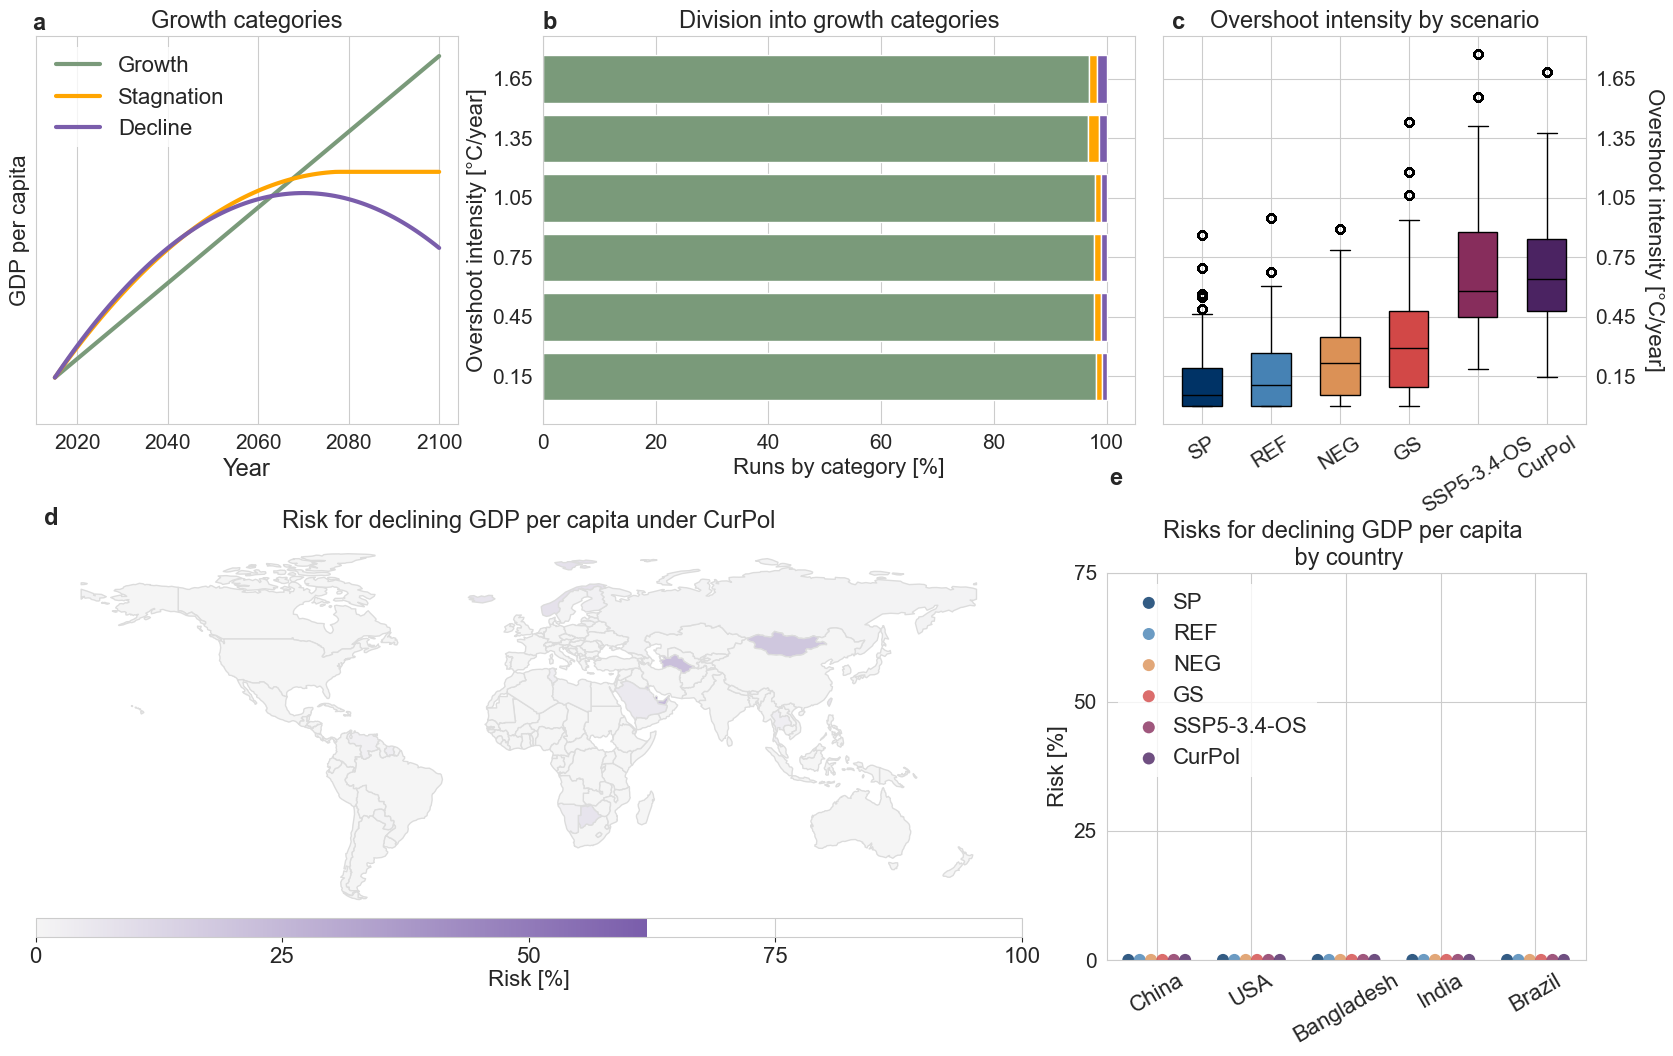

In [20]:
# build one graphic 
colors_clusters = colors = ['#7A9A7A', 
                            'orange', 
                            '#7A5DAB']
axes = []
with sns.axes_style('whitegrid'): 
        fig = plt.figure(figsize=(20, 12))
        gs  = GridSpec(16, 28, figure=fig, hspace = 1, wspace = 1)

        # add categorization:
        ax = fig.add_subplot(gs[:7,:8])
        ax.plot(years, y_growth_constant, color = colors_clusters[0], lw = 3, label = 'Growth')
        ax.plot(years, y_stagnation_normal, color = colors_clusters[1], lw = 3, label = 'Stagnation')
        ax.plot(years, y_nogrowth_normal,  color = colors_clusters[2], lw = 3, label = 'Decline')
        
        ax.set_ylim(bottom = -2, top = 2.2)
        ax.set_yticks([])
        ax.set_xticks([2020,2040,2060,2080,2100],
                        [2020,2040,2060,2080,2100], 
                        fontsize = labelsize_small) 
        ax.set_ylabel('GDP per capita',
                        fontsize = labelsize_medium)
        ax.set_xlabel('Year', 
                        fontsize = labelsize_large)
        ax.legend(edgecolor = 'none', 
                facecolor = (1,1,1,.7), 
                fontsize = labelsize_medium,
                ncols = 1, 
                loc = 'upper left')
        ax.set_title('Growth categories',
                     fontsize = labelsize_large)
        ax.text(2010, 2.27, 'a', fontsize = labelsize_large, fontweight = 'bold')
        axes.append(ax)
        
        # add worldmap
        ax = fig.add_subplot(gs[8:,:18])
        scenario = 'CurPol'
        divider = make_axes_locatable(ax)
        cax = divider.append_axes(position = 'bottom', size='5%', pad=0.01)
        cmap2 = LinearSegmentedColormap.from_list('cmap2', ['whitesmoke',  colors_clusters[-1]])
        cmap2.set_under('whitesmoke')
        cmap2.set_bad('grey')
        world.plot(column=f'no_growth_count_{scenario}', 
                   ax=ax, 
                   legend=True, 
                   cmap = cmap2, 
                   cax = cax, 
                   vmin = 0, 
                   edgecolor = 'gainsboro', 
                   legend_kwds={'orientation': 'horizontal'}
                   )
        cax.set_xticks([0,25,50,75,100],
                       [0,25,50,75,100],
                       fontsize = labelsize_medium)
        cax.set_title('Risk [%]',
                      fontsize = labelsize_medium,
                      y=-3)
        ax.set_axis_off()    
        ax.set_title('Risk for declining GDP per capita under CurPol', 
                fontsize = labelsize_large)   
        ax.text(-195, 95, 'd', fontsize = labelsize_large, fontweight = 'bold')
        axes.append(ax)
        
        # bar plot counts
        ax = fig.add_subplot(gs[:7,9:20])
        bottoms = [0]*n_bins
        width = bin_centers[0]*1.6
        total = np.sum(hist_counts_all, axis = 0)
        hspace = 7
        deltah = 4
        for i in range(3):
                ax.barh(bin_centers,
                np.array(hist_counts_all)[i]/total*100,
                left = bottoms, 
                color = colors_clusters[i],
                height = width)
                bottoms += np.array(hist_counts_all)[i]/total*100
        ax.set_xticks([0, 20, 40, 60, 80, 100], 
                        [0, 20, 40, 60, 80, 100],
                        fontsize = labelsize_small)
        ax.set_yticks(np.round(bin_centers,2),
                        np.round(bin_centers,2),
                        fontsize = labelsize_small)
        ax.set_ylabel('Overshoot intensity [°C/year]', 
                        fontsize = labelsize_medium)
        ax.set_xlabel('Runs by category [%]', 
                        fontsize = labelsize_medium)
        ax.set_title('Division into growth categories',
                     fontsize = labelsize_large)
        ax.text(0, 1.9, 'b', fontsize = labelsize_large, fontweight = 'bold')
        axes.append(ax)
        
        # add bpxplot
        ax = fig.add_subplot(gs[:7,20:], sharey = axes[-1])
        for i, scen in enumerate(focus_scenarios):
                bar = ax.boxplot(classification_df[classification_df.scen == scen].loc[:, 'gmt_exc'].values,
                                positions = [hspace*i], 
                                widths = deltah, 
                                patch_artist = True, 
                                boxprops=dict(facecolor=focus_scenarios_color_dict[scen], color='black'),
                                vert = True,
                                notch = False) 
                for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
                        plt.setp(bar[element], color='black')
        ax.set_xticks([hspace*i for i in range(len(focus_scenarios))], 
                        focus_scenarios_labels,
                        fontsize = labelsize_small,
                        rotation = 32)    
        ax.yaxis.set_tick_params(labelleft=False, labelright = True, labelsize  = labelsize_small)
        ax.yaxis.set_label_position('right')
        ax.set_ylabel('Overshoot intensity [°C/year]',
                      fontsize = labelsize_medium, 
                      rotation = 270,
                      labelpad = 20)
        # ax.set_yticklabels()
        ax.set_title('Overshoot intensity by scenario',
                     fontsize = labelsize_large)
        ax.text(-3, 1.9, 'c', fontsize = labelsize_large, fontweight = 'bold')
        axes.append(ax)
        
        ax = fig.add_subplot(gs[9:,19:])
        
        sel_isos      = ['CHN', 'USA', 'BGD', 'IND', 'BRA'] 
        iso_names = ['China', 'USA', 'Bangladesh', 'India', 'Brazil']
        width = 0.2

        for i, scen in enumerate(focus_scenarios):
                ax.scatter(np.linspace(0.2,0.8,len(focus_scenarios))[i]+np.arange(len(sel_isos)),
                        world.loc[sel_isos, f'no_growth_count_{scen}'].values, 
                        label = focus_scenarios_labels[i], 
                        color = focus_scenarios_color_dict[scen],
                        alpha = .8, 
                        edgecolor = 'none',
                        s = 75)
        ax.set_xticks(np.arange(len(sel_isos))+0.5, 
                iso_names,
                fontsize = labelsize_medium, 
                rotation = 30)
        ax.set_ylabel('Risk [%]', 
                fontsize = labelsize_medium)
        ax.set_yticks([0,25,50,75], 
                [0,25,50,75],
                fontsize = labelsize_small)
        ax.legend(loc = 'upper left', 
                ncols  = 1,
                edgecolor = 'none',
                facecolor = (1,1,1,0.7), 
                fontsize = labelsize_medium, 
                handletextpad=0.1,
                columnspacing=0.2)
        ax.set_title('Risks for declining GDP per capita \n by country',
                fontsize = labelsize_large)
        ax.text(0, 92, 'e', fontsize = labelsize_large, fontweight = 'bold')
        plt.savefig(cset.path_GRAPHICS / 'paper/v0/004_results.pdf', dpi = 600)
        # fig.tight_layout()
        plt.show()

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:937: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.draw()
/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_18846/2531777647.py:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


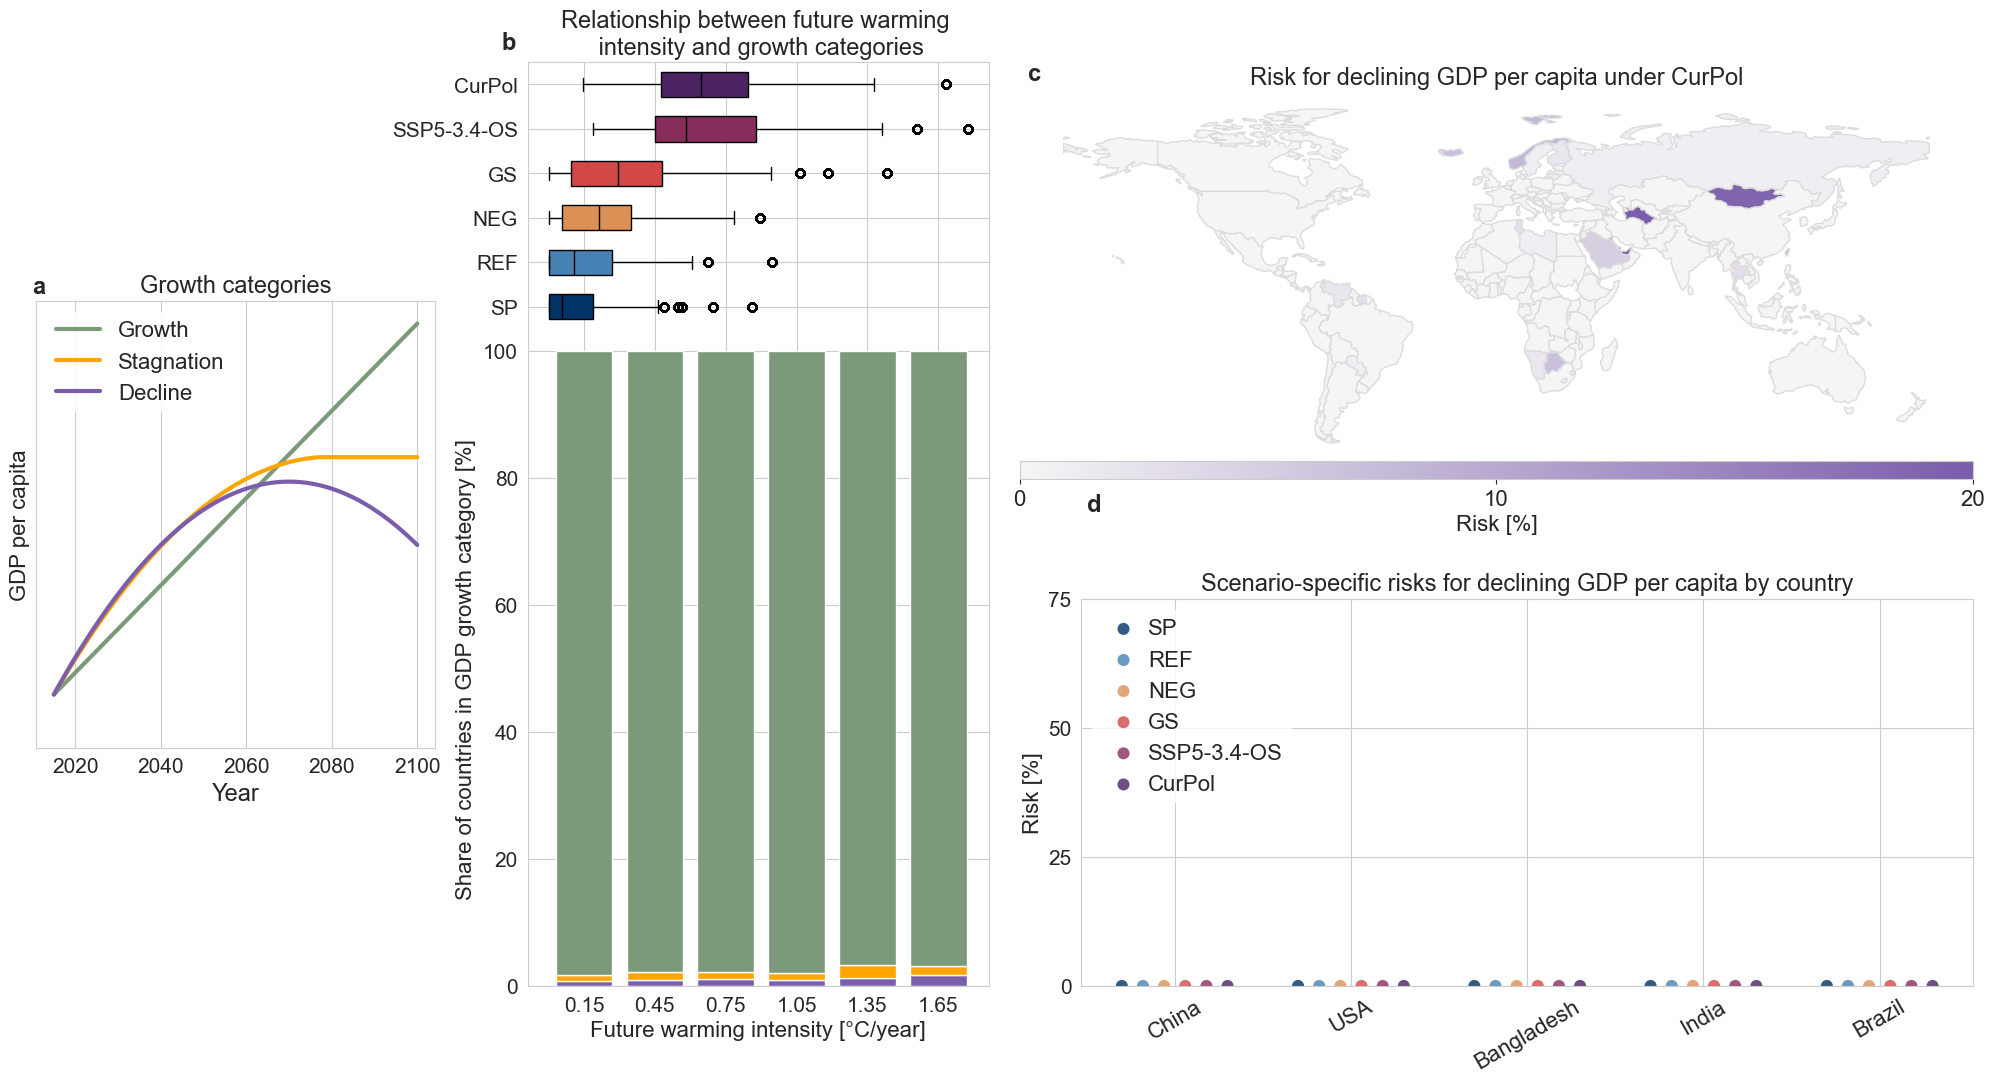

In [24]:
# build one graphic 
colors_clusters = colors = ['#7A9A7A', 
                            'orange', 
                            '#7A5DAB']
axes = []
with sns.axes_style('whitegrid'): 
        fig = plt.figure(figsize=(25, 12), layout = 'tight')
        gs  = GridSpec(16, 32, figure=fig, hspace = 1, wspace = 1)
        # add categorization:
        ax = fig.add_subplot(gs[4:-4,:7])
        ax.plot(years, y_growth_constant, color = colors_clusters[0], lw = 3, label = 'Growth')
        ax.plot(years, y_stagnation_normal, color = colors_clusters[1], lw = 3, label = 'Stagnation')
        ax.plot(years, y_nogrowth_normal,  color = colors_clusters[2], lw = 3, label = 'Decline')
        
        ax.set_ylim(bottom = -2, top = 2.2)
        ax.set_yticks([])
        ax.set_xticks([2020,2040,2060,2080,2100],
                        [2020,2040,2060,2080,2100], 
                        fontsize = labelsize_small) 
        ax.set_ylabel('GDP per capita',
                        fontsize = labelsize_medium)
        ax.set_xlabel('Year', 
                        fontsize = labelsize_large)
        ax.legend(edgecolor = 'none', 
                facecolor = (1,1,1,.7), 
                fontsize = labelsize_medium,
                ncols = 1, 
                loc = 'upper left')
        ax.set_title('Growth categories',
                     fontsize = labelsize_large)
        ax.text(2010, 2.27, 'a', fontsize = labelsize_large, fontweight = 'bold')
        axes.append(ax)     
        
        # bar plot counts
        ax = fig.add_subplot(gs[:,8:16])
        bottoms = [0]*n_bins
        width = bin_centers[0]*1.6
        total = np.sum(hist_counts_all, axis = 0)
        hspace = 7
        deltah = 4
        for i in range(3):
                ax.bar(bin_centers,
                height = np.array(hist_counts_all)[2-i]/total*100,
                bottom = bottoms, 
                color = colors_clusters[2-i],
                width = width)
                bottoms += np.array(hist_counts_all)[2-i]/total*100
        # ax.set_yticks([0, 20, 40, 60, 80, 100], 
        #                 [0, 20, 40, 60, 80, 100],
        #                 fontsize = labelsize_small)
        ax.set_xticks(np.round(bin_centers,2),
                        np.round(bin_centers,2),
                        fontsize = labelsize_small)
        ax.set_xlabel('Future warming intensity [°C/year]', 
                        fontsize = labelsize_medium)
        # ax.set_title('Division into growth categories',
        #              fontsize = labelsize_large)
        hspace = 7
        for i, scen in enumerate(focus_scenarios):
                bar = ax.boxplot(classification_df[classification_df.scen == scen].loc[:, 'gmt_exc'].values,
                                positions = [107 + hspace*i], 
                                widths = deltah, 
                                patch_artist = True, 
                                boxprops=dict(facecolor=focus_scenarios_color_dict[scen], color='black'),
                                vert = False,
                                notch = False) 
                for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
                        plt.setp(bar[element], color='black')
        ax.set_yticks([0, 20, 40, 60, 80, 100] + [107 + hspace*i for i in range(len(focus_scenarios))], 
                       [0, 20, 40, 60, 80, 100] + focus_scenarios_labels,
                        fontsize = labelsize_small)   
        ax.text(-0.35, 50, 'Share of countries in GDP growth category [%]', va = 'center', ha = 'center', rotation = 90, fontsize = labelsize_medium)
        # ax.set_ylabel('Runs by category [%]', 
        #                 fontsize = labelsize_medium,
        #                 loc = 'bottom',
        #                 labelpad = -60)
        ax.set_title('Relationship between future warming \n intensity and growth categories',
                     fontsize = labelsize_large)
        ax.set_ylim(0, 107 + hspace*len(focus_scenarios)-hspace/2)
        ax.text(-0.2, 107 + hspace*len(focus_scenarios)-hspace/2+2, 'b', fontsize = labelsize_large, fontweight = 'bold')
        axes.append(ax)   
        
        # add worldmap
        ax = fig.add_subplot(gs[:8,16:])
        scenario = 'CurPol'
        divider = make_axes_locatable(ax)
        cax = divider.append_axes(position = 'bottom', size='5%', pad=0.01)
        cmap2 = LinearSegmentedColormap.from_list('cmap2', ['whitesmoke',  colors_clusters[-1]])
        cmap2.set_under('whitesmoke')
        cmap2.set_bad('grey')
        world.plot(column=f'no_growth_count_{scenario}', 
                   ax=ax, 
                   legend=True, 
                   cmap = cmap2, 
                   cax = cax, 
                   vmin = 0, 
                   vmax = 20,
                   edgecolor = 'gainsboro', 
                   legend_kwds={'orientation': 'horizontal'}
                   )
        cax.set_xticks([0,10,20],
                       [0,10,20],
                       fontsize = labelsize_medium)
        cax.set_title('Risk [%]',
                      fontsize = labelsize_medium,
                      y=-3.2)
        ax.set_axis_off()    
        ax.set_title('Risk for declining GDP per capita under CurPol', 
                fontsize = labelsize_large)   
        ax.text(-195, 95, 'c', fontsize = labelsize_large, fontweight = 'bold')
        axes.append(ax)

        ax = fig.add_subplot(gs[9:,17:])

        sel_isos      = ['CHN', 'USA', 'BGD', 'IND', 'BRA'] 
        iso_names = ['China', 'USA', 'Bangladesh', 'India', 'Brazil']
        width = 0.2

        for i, scen in enumerate(focus_scenarios):
                ax.scatter(np.linspace(0.2,0.8,len(focus_scenarios))[i]+np.arange(len(sel_isos)),
                        world.loc[sel_isos, f'no_growth_count_{scen}'].values, 
                        label = focus_scenarios_labels[i], 
                        color = focus_scenarios_color_dict[scen],
                        alpha = .8, 
                        edgecolor = 'none',
                        s = 75)
        ax.set_xticks(np.arange(len(sel_isos))+0.5, 
                iso_names,
                fontsize = labelsize_medium, 
                rotation = 30)
        ax.set_ylabel('Risk [%]', 
                fontsize = labelsize_medium)
        ax.set_yticks([0,25,50,75], 
                [0,25,50,75],
                fontsize = labelsize_small)
        ax.legend(loc = 'upper left', 
                ncols  = 1,
                edgecolor = 'none',
                facecolor = (1,1,1,0.7), 
                fontsize = labelsize_medium, 
                handletextpad=0.1,
                columnspacing=0.2)
        ax.set_title('Scenario-specific risks for declining GDP per capita by country',
                fontsize = labelsize_large)
        ax.text(0, 92, 'd', fontsize = labelsize_large, fontweight = 'bold')
        fig.tight_layout()
        plt.savefig(cset.path_GRAPHICS / '004_results.pdf', dpi = 600)
        plt.show()
        
